In [1]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# read data

In [2]:
data1 = np.loadtxt('amp_obs_iso_new_denoise.txt')

data = (data1-np.mean(data1))/np.std(data1)

std=np.std(data1)
mean=np.mean(data1)

#data = data1
print(data.shape)
print(std)
print(mean)

(15851,)
0.5343170313439466
1.2353696918686519


# Regression Model

In [3]:
stackmax=50
H=np.zeros((stackmax,data.shape[0]-stackmax+1))
print(H.shape)

H_tmp=np.zeros((stackmax,data.shape[0]-stackmax+1))

(50, 15802)


In [4]:
for k in range(stackmax):
    H_tmp[k,:] = data[k:len(data)-(stackmax-1-k)]
    
H = H_tmp

#H=np.flip(H,axis=0)

#m = H_tmp.shape[0]
#H = H_tmp -  H_tmp[m//2,:]

In [5]:
U, S, VT = np.linalg.svd(H,full_matrices=0)
V=VT.T
print(V.shape)
print(S)

(15802, 50)
[6.29794416e+02 4.50210083e+02 2.88955333e+02 1.94729141e+02
 1.58983394e+02 1.36720982e+02 1.11891755e+02 8.67728573e+01
 5.88626008e+01 3.64469117e+01 2.24331147e+01 1.41740078e+01
 9.90218134e+00 7.66598170e+00 5.94513806e+00 4.35344086e+00
 3.23776797e+00 2.45934688e+00 1.85893888e+00 1.50211022e+00
 1.41245110e+00 1.35401077e+00 1.27851033e+00 1.20702947e+00
 1.16785077e+00 1.14248345e+00 1.04855527e+00 1.00794706e+00
 1.00016358e+00 9.49422271e-01 8.99745994e-01 8.22642561e-01
 7.71474071e-01 7.52565839e-01 7.30512676e-01 6.99901648e-01
 6.57632040e-01 6.22115168e-01 5.83627194e-01 5.70132447e-01
 5.58204845e-01 5.38482940e-01 5.15919769e-01 4.78513779e-01
 4.68315477e-01 4.55622541e-01 4.44194775e-01 4.35338142e-01
 4.14742433e-01 4.14142667e-01]


In [161]:
r  = 20
r2 = 10
dt = 1
dV = (1/(12*dt))*(-V[4:,0:r] + 8*V[3:-1,0:r] - 8*V[1:-3,0:r] + V[:-4,0:r])
#dV = (1/(12*dt))*(-V[4:,:] + 8*V[3:-1,:] - 8*V[1:-3,:] + V[:-4,:])
V2  = V[2:-2,0:r]
#V2  = V[2:-2,:]
print(dV.shape)
print(V2.shape)
print(len(V))

(15798, 20)
(15798, 20)
15802


In [162]:
Xi = np.linalg.lstsq(V2,dV,rcond=None)[0]
A2  = Xi[:(r-r2),:(r-r2)].T
#B2  = Xi[-r2:,:(r-r2)].T
B2  = Xi[r-r2:r,:r-r2].T
#B2=np.reshape(B2,(16,1))
print(A2.shape)
print(B2.shape)

(10, 10)
(10, 10)


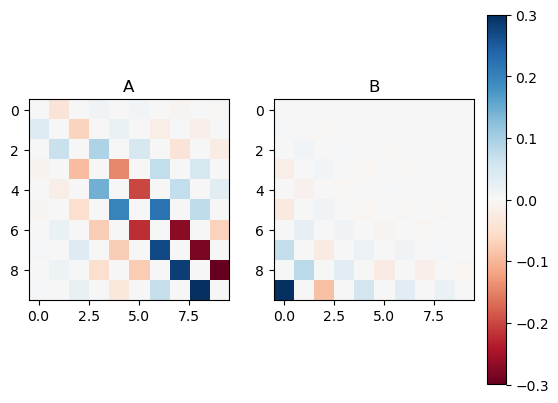

In [163]:
fig = plt.figure()
gs = GridSpec(1, 2, width_ratios=[1, 1.25])

ax0 = plt.subplot(gs[0])
im = ax0.imshow(A2, aspect='equal', cmap=plt.get_cmap('RdBu'),vmin=-0.3, vmax=0.3)
ax0.set(title='A')

ax1 = plt.subplot(gs[1])
im = ax1.imshow(B2, aspect='equal', cmap=plt.get_cmap('RdBu'), vmin=-0.3, vmax=0.3)
ax1.set(title='B')
fig.colorbar(im, ax=ax1)

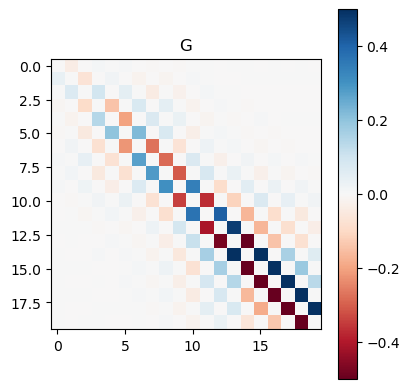

In [164]:
fig = plt.figure()
gs = GridSpec(1, 2, width_ratios=[3, 1])

ax0 = plt.subplot(gs[0])
im = ax0.imshow(Xi[:,:].T, aspect='equal', cmap=plt.get_cmap('RdBu'),vmin=-0.5, vmax=0.5)
ax0.set(title='G')
fig.colorbar(im, ax=ax0)

# Reconstruction

In [165]:
from scipy.signal import lsim
from scipy.signal import lti

n_delays = stackmax-1
t=np.arange(0,len(data))
t0_2=0
t0=n_delays*1+t0_2

Ur = U[:, : r]
sr = S[: r]
VrT = VT[: r, :]
Vr = VrT.T

ur = Ur[:, :-r2] @ np.diag(sr[:-r2])


#A2[0,:]=0.0
#A2[:,0]=0.0
#B2[:-1,:]=0.0

print(ur.shape)
y0 = (
        # np.linalg.inv(np.diag(self.svals[: self.svd_rank - 1]))
        # @
        np.linalg.pinv(ur)
        @ H[:,t0_2].T
     )

#y0 = Vr[0,:r-r2]

sys = lti(
        #Xi[:(r-r2),:(r-r2)].T,
        #Xi[-r2:,:(r-r2)].reshape(r-r2, r2),
        A2,
        B2,
        ur,
        np.zeros((stackmax, r2)),
        )

tout, ypred, xpred = lsim(sys, U=Vr[t0_2:,-r2:], T=t[t0:]-t[t0], X0=y0)
tout2, ypred2, xpred2 = lsim(sys, U=Vr[t0_2:,-r2:]*0, T=t[t0:]-t[t0], X0=y0)

(50, 10)


In [166]:
ypred_res = data[t0_2:-n_delays] - ypred2[:,0]
ypred_res2 = ypred[:,0] - ypred2[:,0]

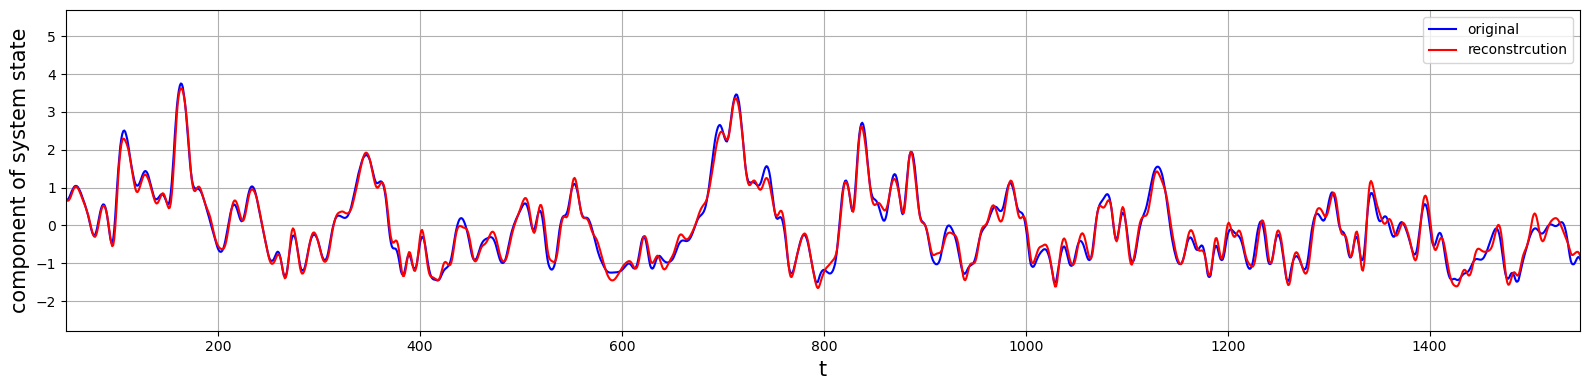

In [167]:
INDEX = [0]
fig, axs = plt.subplots(len(INDEX), 1, tight_layout=True, figsize=(16, 4*len(INDEX)))

if len(INDEX) > 1:
    for i, j in enumerate(INDEX):
        axs[i].plot(t[n_delays:], x[n_delays:, j], '-b', label=f'x_{j}')
        axs[i].plot(t[n_delays:], xpred[:,i], '--r', label=f'xpred_{j}')
    for i in range(2):
        axs[i].grid()
        axs[i].set_xlabel('t',size=15)
        axs[i].set_ylabel('component of system state', size=15)
        axs[i].legend(loc='best')
        axs[i].set_xlim([0, 50])
        axs[i].set_ylim([-50, 50])
else:
    #axs.plot(t[t0_2:], data[t0_2:], '-b',  label='original')
    axs.plot(t[t0:], H[-1,t0_2:], '-b',  label='original')
    #axs.plot(t[t0_2:-n_delays], ypred_res[:], '-g',  label='forced part')
    #axs.plot(t[t0:], u, '-b',  label='forcing')
    axs.plot(t[t0:], ypred[:,-1], '-r', label='reconstrcution')
    #axs.plot(t[t0_2:-n_delays], ypred2[:,0], '--y', label='simulated without forcing')
    #axs.plot(t[t0_2:-n_delays], ypred_res2[:], '--g', label='simulated without forcing')
    axs.grid()
    axs.set_xlabel('t', size=15)
    axs.set_ylabel('component of system state', size=15)
    axs.legend(loc='best')
    plt.xlim([t0+0, t0+1500])
    #plt.ylim([-5, 5])
    #plt.ylim([-0.1, 0.1])
# axs[1].plot(t[n_delays:], x[n_delays:, 2], '--b', label='x_2')
# axs[1].plot(t[n_delays:], xpred[:,1], '--r', label='xpred_2')

    #plt.savefig('Sim_t0.pdf')

In [168]:
R1 = np.corrcoef(H[-1,t0_2:t0_2+1500],ypred[0:1500,-1],rowvar=False)
#R2 = np.corrcoef(data[t0_2:t0_2+1500],ypred2[0:1500,0],rowvar=False)
#R3 = np.corrcoef(data[t0_2:t0_2+1500],ypred_res[0:1500],rowvar=False)
#R4 = np.corrcoef(ypred2[0:1500,0],ypred_res[0:1500],rowvar=False)

print(R1)
#print(R2)
#print(R3)
#print(R4)

[[1.         0.99078097]
 [0.99078097 1.        ]]


In [169]:
np.savetxt('mjo_amp_sim_t0_0_new.txt',ypred[:,-1])

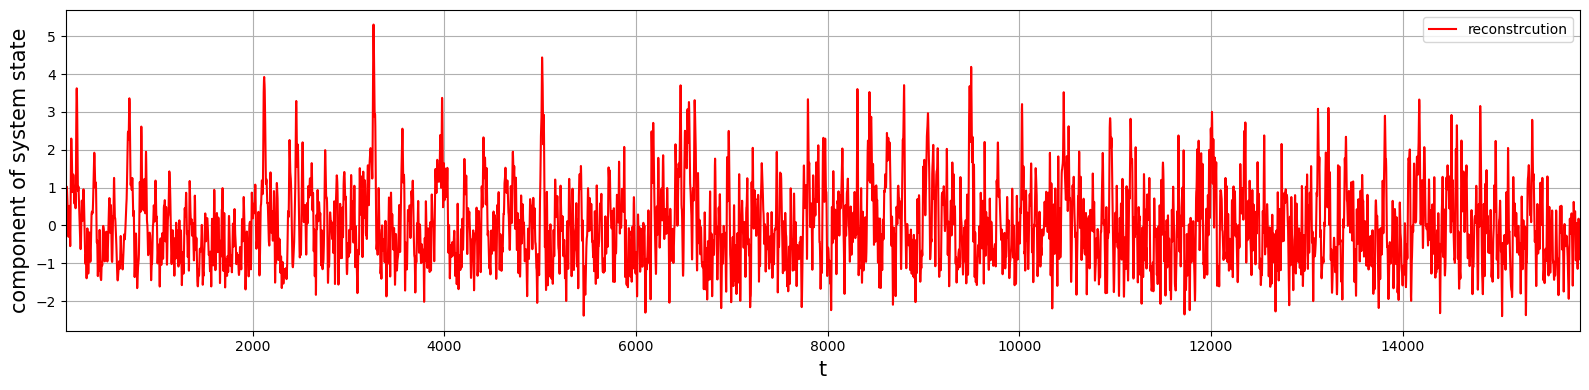

In [170]:
INDEX = [0]
fig, axs = plt.subplots(len(INDEX), 1, tight_layout=True, figsize=(16, 4*len(INDEX)))

if len(INDEX) > 1:
    for i, j in enumerate(INDEX):
        axs[i].plot(t[n_delays:], x[n_delays:, j], '-b', label=f'x_{j}')
        axs[i].plot(t[n_delays:], xpred[:,i], '--r', label=f'xpred_{j}')
    for i in range(2):
        axs[i].grid()
        axs[i].set_xlabel('t',size=15)
        axs[i].set_ylabel('component of system state', size=15)
        axs[i].legend(loc='best')
        axs[i].set_xlim([0, 50])
        axs[i].set_ylim([-50, 50])
else:
    #axs.plot(t[t0_2:], data[t0_2:], '-b',  label='original')
    #axs.plot(t[t0_2:-n_delays], H[0,t0_2:], '-b',  label='original')
    #axs.plot(t[t0_2:-n_delays], ypred_res[:], '-g',  label='forced part')
    #axs.plot(t[t0:], u, '-b',  label='forcing')
    axs.plot(t[t0:], ypred[:,-1], '-r', label='reconstrcution')
    #axs.plot(t[t0_2:-n_delays], ypred2[:,0], '--y', label='simulated without forcing')
    #axs.plot(t[t0_2:-n_delays], ypred_res2[:], '--g', label='simulated without forcing')
    axs.grid()
    axs.set_xlabel('t', size=15)
    axs.set_ylabel('component of system state', size=15)
    axs.legend(loc='best')
    plt.xlim([t0+0, t0+15800])
    #plt.ylim([-5, 5])
    #plt.ylim([-0.1, 0.1])
# axs[1].plot(t[n_delays:], x[n_delays:, 2], '--b', label='x_2')
# axs[1].plot(t[n_delays:], xpred[:,1], '--r', label='xpred_2')
    plt.savefig('FullSim.pdf')

# Eigenvalues

In [18]:
W_A2, V_A2 = np.linalg.eig(A2[:,:])
print(W_A2)

[-1.22606100e-05+0.44992616j -1.22606100e-05-0.44992616j
  2.79259693e-05+0.35085846j  2.79259693e-05-0.35085846j
 -1.56512040e-05+0.0390546j  -1.56512040e-05-0.0390546j
  2.40792650e-05+0.12744739j  2.40792650e-05-0.12744739j
 -5.27271666e-06+0.24535329j -5.27271666e-06-0.24535329j]


In [19]:
print(np.imag(W_A2))
from math import pi
print(np.imag(W_A2[0::2])/(2*pi))
print(2*pi/np.imag(W_A2[0::2]))

[ 0.44992616 -0.44992616  0.35085846 -0.35085846  0.0390546  -0.0390546
  0.12744739 -0.12744739  0.24535329 -0.24535329]
[0.07160797 0.05584086 0.00621573 0.02028388 0.03904919]
[ 13.96492543  17.90803438 160.88209631  49.3002288   25.60872677]


(-0.5, 0.5)

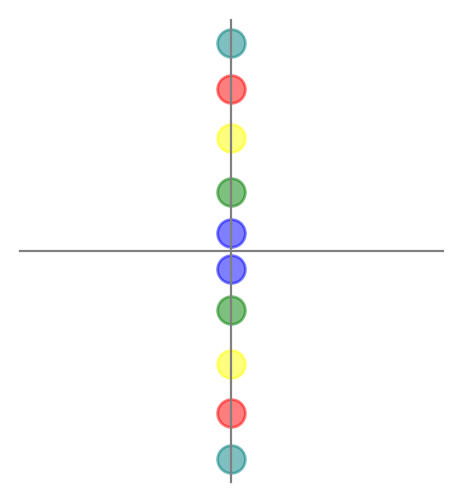

In [20]:
plt.figure(figsize=(6,3),dpi=200)

colors=['teal','red','blue','green','yellow']

# sHAVOK dynamics matrix 

ax = plt.subplot(1,2,1)
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.xticks([])
plt.yticks([])

for i in range(5):
    k=0+i*2
    plt.plot(W_A2.real[k:k+2],W_A2.imag[k:k+2],'o',color=colors[i],markersize=10,label='HAVOK',alpha=0.5)

plt.xlim([-0.5,0.5])
plt.ylim([-0.5,0.5])
#plt.savefig('pdf_files/fig8a.pdf')

In [18]:
print(ur.shape)
A3 = ur @ A2
print(A3.shape)

(50, 10)
(50, 10)


# Testing for dynamic understanding

In [21]:
from math import sqrt
V_A2_trans=np.zeros(V_A2.shape)
#matrix_tmp1= np.real(V_A2[0::2,0::2])
#matrix_tmp2=np.imag(V_A2[1::2,1::2])#*-1.0
matrix_tmp1= np.real(V_A2[:,0::2]+V_A2[:,1::2])/2.0
matrix_tmp2=np.imag(V_A2[:,0::2]-V_A2[:,1::2])/2.0
matrix_tmp1 = matrix_tmp1 * sqrt(2.0)
matrix_tmp2 = matrix_tmp2 * sqrt(2.0)

In [22]:
# method 1
#V_A2_trans[0::2,0::2]=matrix_tmp1
##V_A2_trans[0::2,1::2]=np.imag(V_A2[1::2,1::2])
#V_A2_trans[1::2,1::2]=matrix_tmp2
##V_A2_trans[1::2,0::2]=np.real(V_A2[0::2,0::2])*-1.0

# method 2
V_A2_trans[:,0::2]=matrix_tmp1
#V_A2_trans[0::2,1::2]=np.imag(V_A2[1::2,1::2])
V_A2_trans[:,1::2]=matrix_tmp2
#V_A2_trans[1::2,0::2]=np.real(V_A2[0::2,0::2])*-1.0

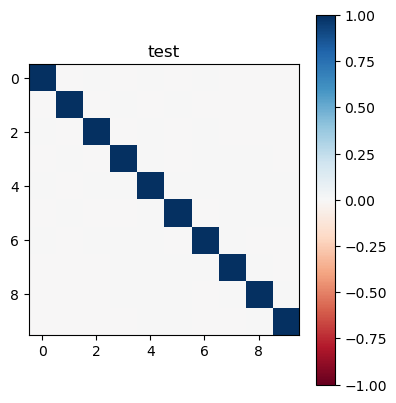

In [23]:
tmp = V_A2_trans @ V_A2_trans.T

fig = plt.figure()
gs = GridSpec(1, 2, width_ratios=[3, 1])

ax0 = plt.subplot(gs[0])
im = ax0.imshow(tmp, aspect='equal', cmap=plt.get_cmap('RdBu'),vmin=-1, vmax=1)
ax0.set(title='test')


fig.colorbar(im, ax=ax0)

In [24]:
A2_trans= V_A2_trans.T @ A2 @ V_A2_trans
B2_trans= V_A2_trans.T @ B2# @ V_A2_trans

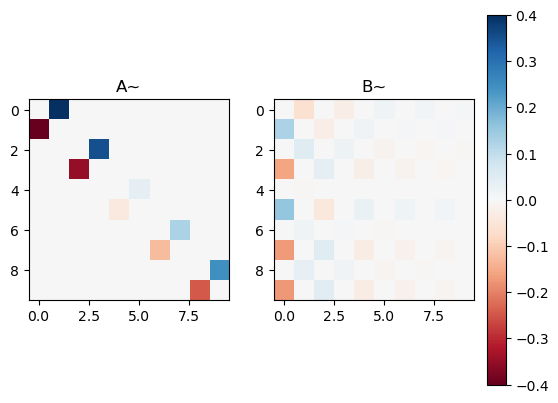

In [25]:
fig = plt.figure()
gs = GridSpec(1, 2, width_ratios=[1, 1.25])

ax0 = plt.subplot(gs[0])
im = ax0.imshow(A2_trans, aspect='equal', cmap=plt.get_cmap('RdBu'),vmin=-0.4, vmax=0.4)
ax0.set(title='A~')
#fig.colorbar(im, ax=ax0)

ax1 = plt.subplot(gs[1])
im = ax1.imshow(B2_trans, aspect='equal', cmap=plt.get_cmap('RdBu'), vmin=-0.4, vmax=0.4)
ax1.set(title='B~')
fig.colorbar(im, ax=ax1)



In [26]:
W_A2_trans_2, V_A2_trans_2 = np.linalg.eig(A2_trans[:,:])
print(W_A2_trans_2)
print(W_A2)
print(2*pi/np.imag(W_A2_trans_2[::2]))
print(2*pi/np.imag(W_A2[0::2]))

[-1.22605437e-05+0.44992632j -1.22605437e-05-0.44992632j
  2.79258880e-05+0.35085838j  2.79258880e-05-0.35085838j
 -5.27269643e-06+0.24535322j -5.27269643e-06-0.24535322j
 -1.56511967e-05+0.03905458j -1.56511967e-05-0.03905458j
  2.40792525e-05+0.12744737j  2.40792525e-05-0.12744737j]
[-1.22606100e-05+0.44992616j -1.22606100e-05-0.44992616j
  2.79259693e-05+0.35085846j  2.79259693e-05-0.35085846j
 -1.56512040e-05+0.0390546j  -1.56512040e-05-0.0390546j
  2.40792650e-05+0.12744739j  2.40792650e-05-0.12744739j
 -5.27271666e-06+0.24535329j -5.27271666e-06-0.24535329j]
[ 13.96492065  17.90803807  25.60873366 160.8821824   49.30023667]
[ 13.96492543  17.90803438 160.88209631  49.3002288   25.60872677]


In [27]:
Forcing_trans = B2_trans @ VrT[-r2:,0:]
print(Forcing_trans.shape)

(10, 15802)


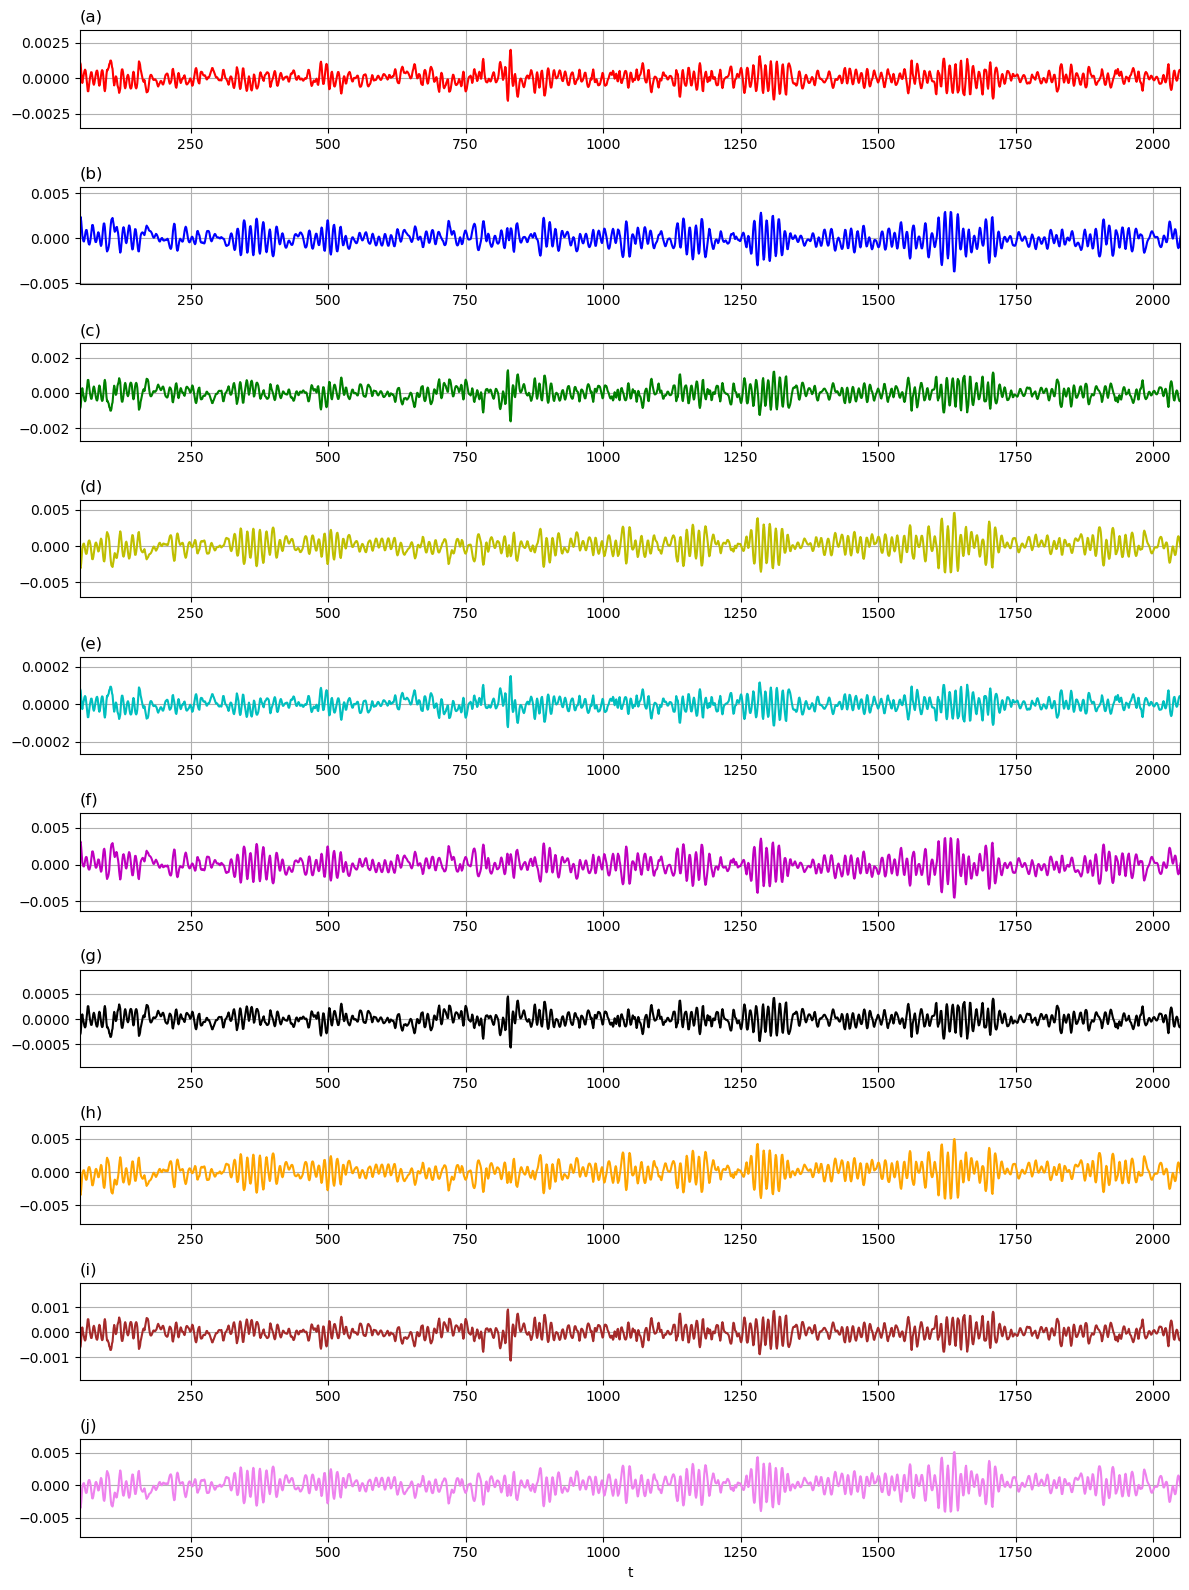

In [28]:
fig, axs = plt.subplots(10, 1, tight_layout=True, figsize=(12, 16))
#plt.xlim([200, 1000])

axs[0].set_title('(a)',loc="left",fontsize=12)
axs[0].plot(t[t0_2:-n_delays], Forcing_trans[0,:], '-r', label='f1')
axs[0].grid()
#plt.xlim([200, 1000])
#plt.ylim([-3.0, 3.0])
axs[0].set_xlim([t0+0, t0+2000])

axs[1].set_title('(b)',loc="left",fontsize=12)
axs[1].plot(t[t0_2:-n_delays], Forcing_trans[1,:], '-b', label='f2')
#axs[1].plot(t[t0_2:-n_delays], np.absolute(u)[:]*1, '-r', label='v14')
#axs[1].plot(t[t0_2:-n_delays], np.absolute(u)[:]*0+0.005, '-k', label='v14')
axs[1].grid()
axs[1].set_xlim([t0+0, t0+2000])

axs[2].set_title('(c)',loc="left",fontsize=12)
axs[2].plot(t[t0_2:-n_delays], Forcing_trans[2,:], '-g', label='f3')
axs[2].grid()
axs[2].set_xlim([t0+0, t0+2000])

axs[3].set_title('(d)',loc="left",fontsize=12)
axs[3].plot(t[t0_2:-n_delays], Forcing_trans[3,:], '-y', label='f4')
axs[3].grid()
axs[3].set_xlim([t0+0, t0+2000])

axs[4].set_title('(e)',loc="left",fontsize=12)
axs[4].plot(t[t0_2:-n_delays], Forcing_trans[4,:], '-c', label='f5')
axs[4].grid()
axs[4].set_xlim([t0+0, t0+2000])

axs[5].set_title('(f)',loc="left",fontsize=12)
axs[5].plot(t[t0_2:-n_delays], Forcing_trans[5,:], '-m', label='f6')
axs[5].grid()
axs[5].set_xlim([t0+0, t0+2000])

axs[6].set_title('(g)',loc="left",fontsize=12)
axs[6].plot(t[t0_2:-n_delays], Forcing_trans[6,:], '-k', label='f7')
axs[6].grid()
axs[6].set_xlim([t0+0, t0+2000])

axs[7].set_title('(h)',loc="left",fontsize=12)
axs[7].plot(t[t0_2:-n_delays], Forcing_trans[7,:], linestyle='-',color='orange', label='f8')
axs[7].grid()
axs[7].set_xlim([t0+0, t0+2000])

axs[8].set_title('(i)',loc="left",fontsize=12)
axs[8].plot(t[t0_2:-n_delays], Forcing_trans[8,:], linestyle='-',color='brown', label='f9')
axs[8].grid()
axs[8].set_xlim([t0+0, t0+2000])

axs[9].set_title('(j)',loc="left",fontsize=12)
axs[9].plot(t[t0_2:-n_delays], Forcing_trans[9,:], linestyle='-',color='violet', label='f10')
axs[9].grid()

axs[9].set_xlabel('t')
#axs[9].legend(loc='best')
axs[9].set_xlim([t0+0, t0+2000])
#plt.ylim([-.3, .3])
plt.savefig('forcing_all.pdf')

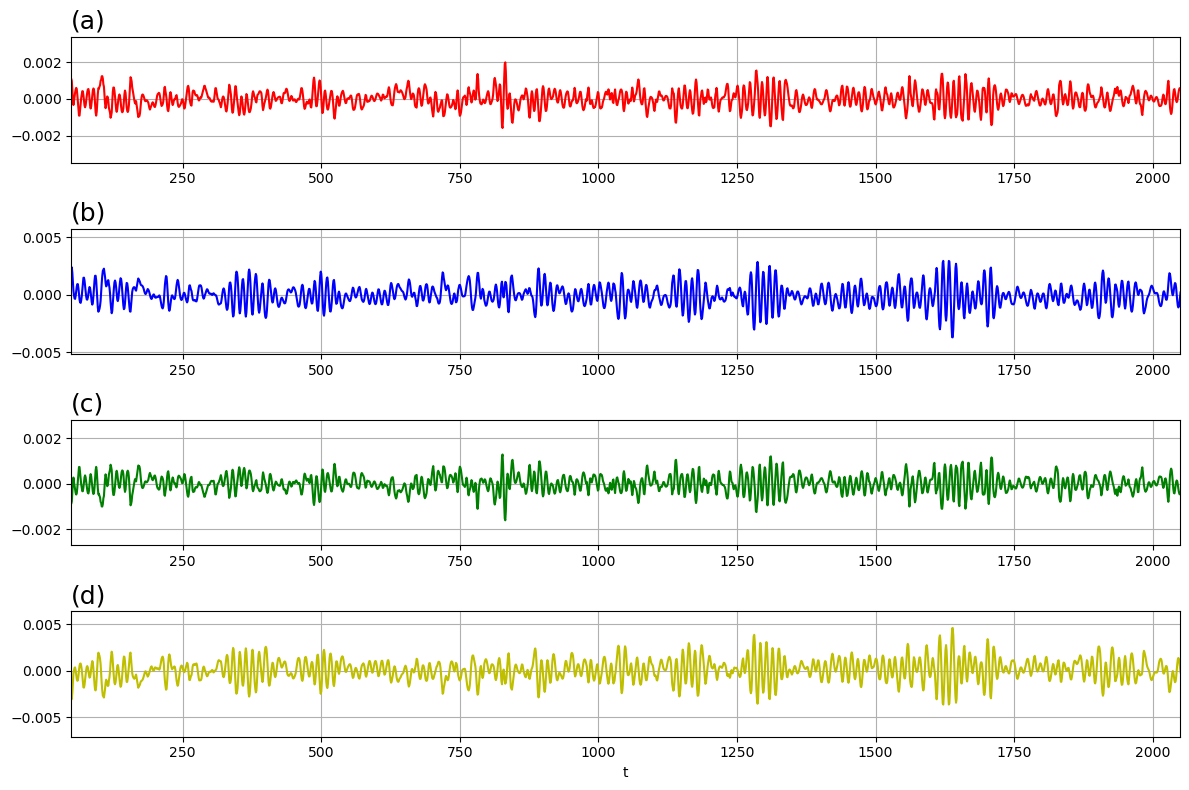

In [29]:
fig, axs = plt.subplots(4, 1, tight_layout=True, figsize=(12, 8))
#plt.xlim([200, 1000])

#axs[0].set(title='(A)')
axs[0].set_title('(a)',loc="left",fontsize=18)
axs[0].plot(t[t0_2:-n_delays], Forcing_trans[0,:], '-r', label='f1')
axs[0].grid()
#plt.xlim([200, 1000])
#plt.ylim([-3.0, 3.0])
axs[0].set_xlim([t0+0, t0+2000])

#axs[1].set(title='(B)')
axs[1].set_title('(b)',loc="left",fontsize=18)
axs[1].plot(t[t0_2:-n_delays], Forcing_trans[1,:], '-b', label='f2')
#axs[1].plot(t[t0_2:-n_delays], np.absolute(u)[:]*1, '-r', label='v14')
#axs[1].plot(t[t0_2:-n_delays], np.absolute(u)[:]*0+0.005, '-k', label='v14')
axs[1].grid()
axs[1].set_xlim([t0+0, t0+2000])

#axs[2].set(title='(C)')
axs[2].set_title('(c)',loc="left",fontsize=18)
axs[2].plot(t[t0_2:-n_delays], Forcing_trans[2,:], '-g', label='f3')
axs[2].grid()
axs[2].set_xlim([t0+0, t0+2000])

#axs[3].set(title='(D)')
axs[3].set_title('(d)',loc="left",fontsize=18)
axs[3].plot(t[t0_2:-n_delays], Forcing_trans[3,:], '-y', label='f4')
axs[3].grid()
axs[3].set_xlim([t0+0, t0+2000])
axs[3].set_xlabel('t')
#axs[9].legend(loc='best')

plt.savefig('forcing_1-4.pdf')

In [30]:
np.savetxt('mjo_forcing_trans_t0_0_new.txt',Forcing_trans[:,:])
print(Forcing_trans[0,0:10])

[ 0.00035638  0.00053667  0.0005735   0.00043087  0.00011297 -0.00023336
 -0.00044103 -0.00052297 -0.00041993 -0.00020708]


In [31]:
ur_trans = ur @ V_A2_trans


#A2[0,:]=0.0
#A2[:,0]=0.0
#B2[:-1,:]=0.0

print(ur.shape)
y0 = (
        # np.linalg.inv(np.diag(self.svals[: self.svd_rank - 1]))
        # @
        np.linalg.pinv(ur)
        @ H[:,t0_2].T
     )

#y0 = Vr[0,:r-r2]

y0 = V_A2_trans.T @ y0

sys = lti(
        #Xi[:(r-r2),:(r-r2)].T,
        #Xi[-r2:,:(r-r2)].reshape(r-r2, r2),
        A2_trans,
        B2_trans,
        ur_trans,
        np.zeros((stackmax, r2)),
        )

tout_trans, ypred_trans, xpred_trans = lsim(sys, U=Vr[t0_2:,-r2:], T=t[t0:]-t[t0], X0=y0)


(50, 10)


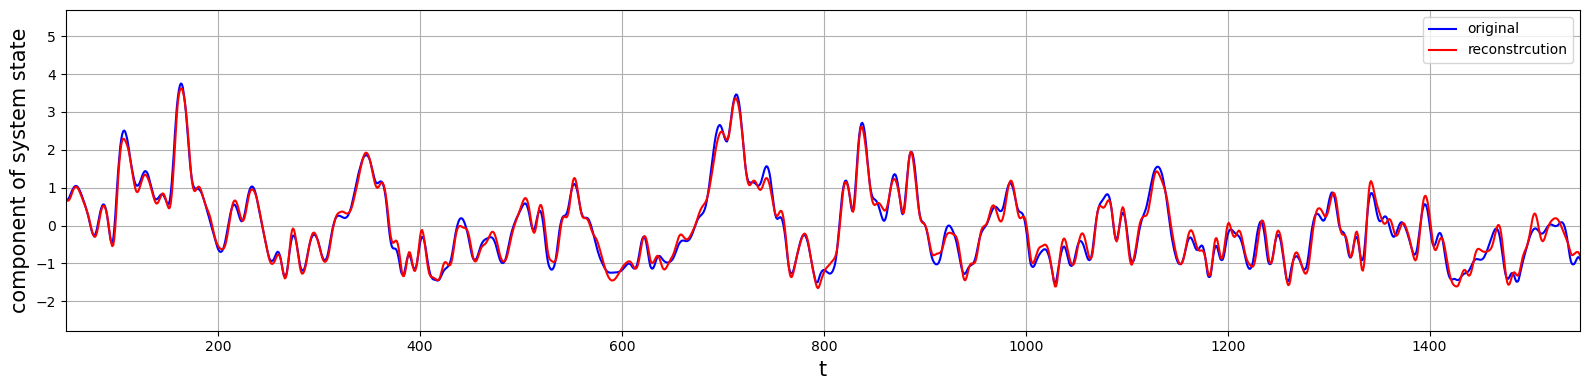

In [32]:
INDEX = [0]
fig, axs = plt.subplots(len(INDEX), 1, tight_layout=True, figsize=(16, 4*len(INDEX)))

if len(INDEX) > 1:
    for i, j in enumerate(INDEX):
        axs[i].plot(t[n_delays:], x[n_delays:, j], '-b', label=f'x_{j}')
        axs[i].plot(t[n_delays:], xpred[:,i], '--r', label=f'xpred_{j}')
    for i in range(2):
        axs[i].grid()
        axs[i].set_xlabel('t',size=15)
        axs[i].set_ylabel('component of system state', size=15)
        axs[i].legend(loc='best')
        axs[i].set_xlim([0, 50])
        axs[i].set_ylim([-50, 50])
else:
    #axs.plot(t[t0_2:], data[t0_2:], '-b',  label='original')
    axs.plot(t[t0:], H[-1,t0_2:], '-b',  label='original')
    #axs.plot(t[t0_2:-n_delays], ypred_res[:], '-g',  label='forced part')
    #axs.plot(t[t0:], u, '-b',  label='forcing')
    axs.plot(t[t0:], ypred_trans[:,-1], '-r', label='reconstrcution')
    #axs.plot(t[t0_2:-n_delays], ypred2[:,0], '--y', label='simulated without forcing')
    #axs.plot(t[t0_2:-n_delays], ypred_res2[:], '--g', label='simulated without forcing')
    axs.grid()
    axs.set_xlabel('t', size=15)
    axs.set_ylabel('component of system state', size=15)
    axs.legend(loc='best')
    plt.xlim([t0+0, t0+1500])
    #plt.ylim([-5, 5])
    #plt.ylim([-0.1, 0.1])
# axs[1].plot(t[n_delays:], x[n_delays:, 2], '--b', label='x_2')
# axs[1].plot(t[n_delays:], xpred[:,1], '--r', label='xpred_2')